TP1 - Recalage d'images
=============

In [1]:
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
import cv2


import warnings
warnings.filterwarnings("ignore")

In [2]:
def interpol(f,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d #retourne dx*im
def dy(im) :
    d=np.zeros(im.shape)
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d
def dxT(im) :
    d=np.zeros(im.shape)
    d[0,:] = -im[0,:]
    d[1:-1,:] = im[:-2,:] - im[1:-1:,:]
    d[-1,:] = im[-2,:]
    return d  
def dyT(im) :
    d=np.zeros(im.shape)
    d[:,0] = -im[:,0]
    d[:,1:-1] = im[:,:-2] - im[:,1:-1]
    d[:,-1] = im[:,-2]    
    return d

def objective_function(f,g,ux,uy,lamb,mu) :
    fu=interpol(f,ux,uy)
    R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
    E = 1/2*npl.norm(fu  - g)**2
    obj = E + R
    return obj,fu

def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   

        gradEx = (fu - g)*interpol(dx(f),ux,uy)
        gradEy = (fu - g)*interpol(dy(f),ux,uy)
        gradE = np.array([gradEx, gradEy])
        
        
        # Gradient of R at point u
        gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
        gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (lamb + mu)*(dyT(dx(ux)) + dyT(dy(uy)))
        
        
        # Gradient of E+R at point u
        gradx = gradEx + gradRx
        grady = gradEy + gradRy
        
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

#df déjà interpolé
def JPsi(vx,vy,df,lamb,mu) :
    JPsi0 = df[0]*vx+df[1]*vy
    JPsi1 = np.sqrt(mu)*dy(vx)+np.sqrt(mu)*dx(vy)
    JPsi2 = np.sqrt(mu+lamb)*dx(vx)+ np.sqrt(mu+lamb)*dy(vy)
    
    return [JPsi0,JPsi1,JPsi2]

def JTPsi(phi,df,lamb,mu) :
    ux =df[0]*phi[0]+ np.sqrt(mu)*dyT(phi[1])+ np.sqrt(mu+lamb)*dxT(phi[2])
    uy =df[1]*phi[0]+ np.sqrt(mu)*dxT(phi[1])+ np.sqrt(mu+lamb)*dyT(phi[2])

    return [ux,uy]

def JTJ(vx,vy,df,lamb,mu,epsilon) :
    J = JPsi(vx,vy,df,lamb,mu)
    JJ = JTPsi(J,df,lamb,mu)
    #JJ += epsilon*vx + epsilon*vy
    uxs = JJ[0]+epsilon*vx
    uys = JJ[1]+epsilon*vy
    
    return uxs,uys

def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)
    
   
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx=dx(f)
    dfy=dy(f)
    df = [dfx,dfy]
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        dfu=[interpol(dfx,ux,uy),interpol(dfy,ux,uy)] ##on dérive puis on interpole
        phi = [fu - g,np.sqrt(mu)*(dx(uy) + dy(ux)), np.sqrt(mu + lamb)*(dx(ux) + dy(uy))]
        b = JTPsi(phi,dfu,lamb,mu)
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 300 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

def gaussianFilter(img,factor):
    kernel = np.ones((factor,factor),np.float32)/(factor**2)
    return cv2.filter2D(img,-1,kernel)

In [3]:
def get_images():
    band1 = np.loadtxt("band1.txt")
    band2 = np.loadtxt("band2.txt")
    return band1, band2
b1,b2 = get_images()

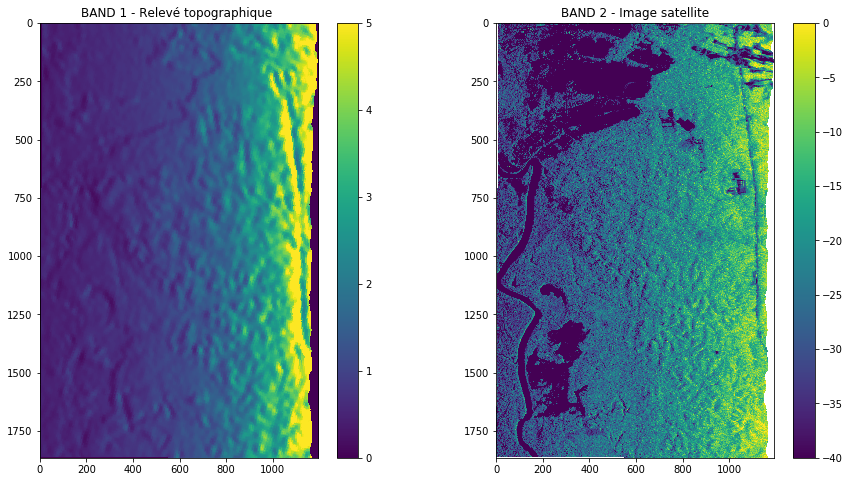

In [4]:
fig,ax = plt.subplots(1,2, figsize=(15,8))

im1 = ax[0].imshow(b1, vmin = 0, vmax = 5)
ax[0].set_title("BAND 1 - Relevé topographique ")
fig.colorbar(im1,ax=ax[0])

im2 = ax[1].imshow(10*np.log(b2),vmin=-40,vmax=0)
ax[1].set_title("BAND 2 - Image satellite")
fig.colorbar(im2,ax=ax[1])

plt.show()

In [15]:
res = []

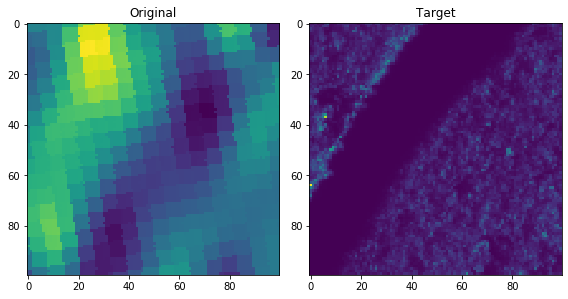

In [9]:
target = b2[1000:1100,10:110]
original = gaussianFilter(b1[1000:1100,10:110],1)
#template = np.roll(target,5,axis=0)


#target = target/(1 + target)
#original = original/(1 + original)

fig, ax = plt.subplots(1,2, figsize=(8,8))
im1 = ax[0].imshow(original)
ax[0].set_title("Original")

im2 = ax[1].imshow(target)
ax[1].set_title("Target")

# ax[1].imshow(template)
# ax[1].set_title("Template (5px shift)")
plt.tight_layout()

plt.savefig("test_images_gradient.png")

plt.show()


## Test optim des param

### Gradient, pas recherche linéaire

In [7]:
lamb = np.linspace(-1,1.5,10)
mu = np.copy(0.1*lamb)
nitertab = np.zeros(10)
nitermax=3000
step0 = 0.01
for i in range(10):
    ux,uy,CF,step,nitertab[i]=RecalageDG(original,target,lamb[i],mu[i],nitermax,step0)

iteration : 3  cost function : 991.5374500195197 step : 0.08
iteration : 6  cost function : 984.101376633787 step : 0.64
iteration : 9  cost function : -13155320.949524537 step : 5.12
iteration : 12  cost function : -7.460336154143987e+18 step : 40.96
iteration : 15  cost function : -1.2382675719935977e+36 step : 327.68
iteration : 18  cost function : -5.807437520125365e+58 step : 2621.44
iteration : 21  cost function : -7.505230040486394e+86 step : 20971.52
iteration : 24  cost function : -2.632641015804514e+120 step : 167772.16
iteration : 27  cost function : -2.4835907290367696e+159 step : 1342177.28
iteration : 30  cost function : -6.264023277819888e+203 step : 10737418.24
iteration : 33  cost function : -4.206741835259272e+253 step : 85899345.92
iteration : 36  cost function : -inf step : 687194767.36
iteration : 39  cost function : -inf step : 5497558138.88
iteration : 42  cost function : -inf step : 43980465111.04
iteration : 45  cost function : -inf step : 351843720888.32
itera

<ipython-input-2-c0f16775b937>:40: RuntimeWarning: overflow encountered in multiply
  tmpx=ux-step*descentx
<ipython-input-2-c0f16775b937>:41: RuntimeWarning: overflow encountered in multiply
  tmpy=uy-step*descenty
<ipython-input-2-c0f16775b937>:12: RuntimeWarning: invalid value encountered in subtract
  d[:-1,:]=im[1:,:]-im[:-1,:]
<ipython-input-2-c0f16775b937>:16: RuntimeWarning: invalid value encountered in subtract
  d[:,:-1]=im[:,1:]-im[:,:-1]
<ipython-input-2-c0f16775b937>:33: RuntimeWarning: invalid value encountered in add
  R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
<ipython-input-2-c0f16775b937>:27: RuntimeWarning: invalid value encountered in subtract
  d[:,1:-1] = im[:,:-2] - im[:,1:-1]
<ipython-input-2-c0f16775b937>:68: RuntimeWarning: invalid value encountered in add
  gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
<ipython-input-2-c0f16775b937>:21: RuntimeWarning: invalid value encountered in subtr

iteration : 57  cost function : nan step : 1441151880758558.8
iteration : 60  cost function : nan step : 1.152921504606847e+16
iteration : 63  cost function : nan step : 9.223372036854776e+16
iteration : 66  cost function : nan step : 7.378697629483821e+17
iteration : 69  cost function : nan step : 5.902958103587057e+18
iteration : 72  cost function : nan step : 4.722366482869645e+19
iteration : 75  cost function : nan step : 3.777893186295716e+20
iteration : 78  cost function : nan step : 3.022314549036573e+21
iteration : 81  cost function : nan step : 2.4178516392292584e+22
iteration : 84  cost function : nan step : 1.9342813113834067e+23
iteration : 87  cost function : nan step : 1.5474250491067254e+24
iteration : 90  cost function : nan step : 1.2379400392853803e+25
iteration : 93  cost function : nan step : 9.903520314283042e+25
iteration : 96  cost function : nan step : 7.922816251426434e+26
iteration : 99  cost function : nan step : 6.338253001141147e+27
iteration : 102  cost fu

iteration : 432  cost function : nan step : 1.109067877648326e+128
iteration : 435  cost function : nan step : 8.872543021186608e+128
iteration : 438  cost function : nan step : 7.098034416949286e+129
iteration : 441  cost function : nan step : 5.678427533559429e+130
iteration : 444  cost function : nan step : 4.542742026847543e+131
iteration : 447  cost function : nan step : 3.6341936214780345e+132
iteration : 450  cost function : nan step : 2.9073548971824276e+133
iteration : 453  cost function : nan step : 2.325883917745942e+134
iteration : 456  cost function : nan step : 1.8607071341967537e+135
iteration : 459  cost function : nan step : 1.488565707357403e+136
iteration : 462  cost function : nan step : 1.1908525658859224e+137
iteration : 465  cost function : nan step : 9.526820527087379e+137
iteration : 468  cost function : nan step : 7.621456421669903e+138
iteration : 471  cost function : nan step : 6.097165137335922e+139
iteration : 474  cost function : nan step : 4.877732109868

iteration : 807  cost function : nan step : 8.535058474086214e+240
iteration : 810  cost function : nan step : 6.828046779268971e+241
iteration : 813  cost function : nan step : 5.462437423415177e+242
iteration : 816  cost function : nan step : 4.3699499387321414e+243
iteration : 819  cost function : nan step : 3.495959950985713e+244
iteration : 822  cost function : nan step : 2.7967679607885705e+245
iteration : 825  cost function : nan step : 2.2374143686308564e+246
iteration : 828  cost function : nan step : 1.789931494904685e+247
iteration : 831  cost function : nan step : 1.431945195923748e+248
iteration : 834  cost function : nan step : 1.1455561567389985e+249
iteration : 837  cost function : nan step : 9.164449253911988e+249
iteration : 840  cost function : nan step : 7.33155940312959e+250
iteration : 843  cost function : nan step : 5.865247522503672e+251
iteration : 846  cost function : nan step : 4.692198018002938e+252
iteration : 849  cost function : nan step : 3.7537584144023

iteration : 1227  cost function : nan step : inf
iteration : 1230  cost function : nan step : inf
iteration : 1233  cost function : nan step : inf
iteration : 1236  cost function : nan step : inf
iteration : 1239  cost function : nan step : inf
iteration : 1242  cost function : nan step : inf
iteration : 1245  cost function : nan step : inf
iteration : 1248  cost function : nan step : inf
iteration : 1251  cost function : nan step : inf
iteration : 1254  cost function : nan step : inf
iteration : 1257  cost function : nan step : inf
iteration : 1260  cost function : nan step : inf
iteration : 1263  cost function : nan step : inf
iteration : 1266  cost function : nan step : inf
iteration : 1269  cost function : nan step : inf
iteration : 1272  cost function : nan step : inf
iteration : 1275  cost function : nan step : inf
iteration : 1278  cost function : nan step : inf
iteration : 1281  cost function : nan step : inf
iteration : 1284  cost function : nan step : inf
iteration : 1287  co

iteration : 1737  cost function : nan step : inf
iteration : 1740  cost function : nan step : inf
iteration : 1743  cost function : nan step : inf
iteration : 1746  cost function : nan step : inf
iteration : 1749  cost function : nan step : inf
iteration : 1752  cost function : nan step : inf
iteration : 1755  cost function : nan step : inf
iteration : 1758  cost function : nan step : inf
iteration : 1761  cost function : nan step : inf
iteration : 1764  cost function : nan step : inf
iteration : 1767  cost function : nan step : inf
iteration : 1770  cost function : nan step : inf
iteration : 1773  cost function : nan step : inf
iteration : 1776  cost function : nan step : inf
iteration : 1779  cost function : nan step : inf
iteration : 1782  cost function : nan step : inf
iteration : 1785  cost function : nan step : inf
iteration : 1788  cost function : nan step : inf
iteration : 1791  cost function : nan step : inf
iteration : 1794  cost function : nan step : inf
iteration : 1797  co

iteration : 2247  cost function : nan step : inf
iteration : 2250  cost function : nan step : inf
iteration : 2253  cost function : nan step : inf
iteration : 2256  cost function : nan step : inf
iteration : 2259  cost function : nan step : inf
iteration : 2262  cost function : nan step : inf
iteration : 2265  cost function : nan step : inf
iteration : 2268  cost function : nan step : inf
iteration : 2271  cost function : nan step : inf
iteration : 2274  cost function : nan step : inf
iteration : 2277  cost function : nan step : inf
iteration : 2280  cost function : nan step : inf
iteration : 2283  cost function : nan step : inf
iteration : 2286  cost function : nan step : inf
iteration : 2289  cost function : nan step : inf
iteration : 2292  cost function : nan step : inf
iteration : 2295  cost function : nan step : inf
iteration : 2298  cost function : nan step : inf
iteration : 2301  cost function : nan step : inf
iteration : 2304  cost function : nan step : inf
iteration : 2307  co

iteration : 2757  cost function : nan step : inf
iteration : 2760  cost function : nan step : inf
iteration : 2763  cost function : nan step : inf
iteration : 2766  cost function : nan step : inf
iteration : 2769  cost function : nan step : inf
iteration : 2772  cost function : nan step : inf
iteration : 2775  cost function : nan step : inf
iteration : 2778  cost function : nan step : inf
iteration : 2781  cost function : nan step : inf
iteration : 2784  cost function : nan step : inf
iteration : 2787  cost function : nan step : inf
iteration : 2790  cost function : nan step : inf
iteration : 2793  cost function : nan step : inf
iteration : 2796  cost function : nan step : inf
iteration : 2799  cost function : nan step : inf
iteration : 2802  cost function : nan step : inf
iteration : 2805  cost function : nan step : inf
iteration : 2808  cost function : nan step : inf
iteration : 2811  cost function : nan step : inf
iteration : 2814  cost function : nan step : inf
iteration : 2817  co

<ipython-input-2-c0f16775b937>:12: RuntimeWarning: overflow encountered in subtract
  d[:-1,:]=im[1:,:]-im[:-1,:]
<ipython-input-2-c0f16775b937>:16: RuntimeWarning: overflow encountered in subtract
  d[:,:-1]=im[:,1:]-im[:,:-1]
<ipython-input-2-c0f16775b937>:33: RuntimeWarning: overflow encountered in add
  R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
<ipython-input-2-c0f16775b937>:27: RuntimeWarning: overflow encountered in subtract
  d[:,1:-1] = im[:,:-2] - im[:,1:-1]
<ipython-input-2-c0f16775b937>:21: RuntimeWarning: overflow encountered in subtract
  d[1:-1,:] = im[:-2,:] - im[1:-1:,:]


iteration : 51  cost function : nan step : 22517998136852.48
iteration : 54  cost function : nan step : 180143985094819.84
iteration : 57  cost function : nan step : 1441151880758558.8
iteration : 60  cost function : nan step : 1.152921504606847e+16
iteration : 63  cost function : nan step : 9.223372036854776e+16
iteration : 66  cost function : nan step : 7.378697629483821e+17
iteration : 69  cost function : nan step : 5.902958103587057e+18
iteration : 72  cost function : nan step : 4.722366482869645e+19
iteration : 75  cost function : nan step : 3.777893186295716e+20
iteration : 78  cost function : nan step : 3.022314549036573e+21
iteration : 81  cost function : nan step : 2.4178516392292584e+22
iteration : 84  cost function : nan step : 1.9342813113834067e+23
iteration : 87  cost function : nan step : 1.5474250491067254e+24
iteration : 90  cost function : nan step : 1.2379400392853803e+25
iteration : 93  cost function : nan step : 9.903520314283042e+25
iteration : 96  cost function :

iteration : 426  cost function : nan step : 1.7329185588255093e+126
iteration : 429  cost function : nan step : 1.3863348470604075e+127
iteration : 432  cost function : nan step : 1.109067877648326e+128
iteration : 435  cost function : nan step : 8.872543021186608e+128
iteration : 438  cost function : nan step : 7.098034416949286e+129
iteration : 441  cost function : nan step : 5.678427533559429e+130
iteration : 444  cost function : nan step : 4.542742026847543e+131
iteration : 447  cost function : nan step : 3.6341936214780345e+132
iteration : 450  cost function : nan step : 2.9073548971824276e+133
iteration : 453  cost function : nan step : 2.325883917745942e+134
iteration : 456  cost function : nan step : 1.8607071341967537e+135
iteration : 459  cost function : nan step : 1.488565707357403e+136
iteration : 462  cost function : nan step : 1.1908525658859224e+137
iteration : 465  cost function : nan step : 9.526820527087379e+137
iteration : 468  cost function : nan step : 7.6214564216

iteration : 801  cost function : nan step : 1.3336028865759709e+239
iteration : 804  cost function : nan step : 1.0668823092607767e+240
iteration : 807  cost function : nan step : 8.535058474086214e+240
iteration : 810  cost function : nan step : 6.828046779268971e+241
iteration : 813  cost function : nan step : 5.462437423415177e+242
iteration : 816  cost function : nan step : 4.3699499387321414e+243
iteration : 819  cost function : nan step : 3.495959950985713e+244
iteration : 822  cost function : nan step : 2.7967679607885705e+245
iteration : 825  cost function : nan step : 2.2374143686308564e+246
iteration : 828  cost function : nan step : 1.789931494904685e+247
iteration : 831  cost function : nan step : 1.431945195923748e+248
iteration : 834  cost function : nan step : 1.1455561567389985e+249
iteration : 837  cost function : nan step : 9.164449253911988e+249
iteration : 840  cost function : nan step : 7.33155940312959e+250
iteration : 843  cost function : nan step : 5.86524752250

iteration : 1221  cost function : nan step : inf
iteration : 1224  cost function : nan step : inf
iteration : 1227  cost function : nan step : inf
iteration : 1230  cost function : nan step : inf
iteration : 1233  cost function : nan step : inf
iteration : 1236  cost function : nan step : inf
iteration : 1239  cost function : nan step : inf
iteration : 1242  cost function : nan step : inf
iteration : 1245  cost function : nan step : inf
iteration : 1248  cost function : nan step : inf
iteration : 1251  cost function : nan step : inf
iteration : 1254  cost function : nan step : inf
iteration : 1257  cost function : nan step : inf
iteration : 1260  cost function : nan step : inf
iteration : 1263  cost function : nan step : inf
iteration : 1266  cost function : nan step : inf
iteration : 1269  cost function : nan step : inf
iteration : 1272  cost function : nan step : inf
iteration : 1275  cost function : nan step : inf
iteration : 1278  cost function : nan step : inf
iteration : 1281  co

iteration : 1734  cost function : nan step : inf
iteration : 1737  cost function : nan step : inf
iteration : 1740  cost function : nan step : inf
iteration : 1743  cost function : nan step : inf
iteration : 1746  cost function : nan step : inf
iteration : 1749  cost function : nan step : inf
iteration : 1752  cost function : nan step : inf
iteration : 1755  cost function : nan step : inf
iteration : 1758  cost function : nan step : inf
iteration : 1761  cost function : nan step : inf
iteration : 1764  cost function : nan step : inf
iteration : 1767  cost function : nan step : inf
iteration : 1770  cost function : nan step : inf
iteration : 1773  cost function : nan step : inf
iteration : 1776  cost function : nan step : inf
iteration : 1779  cost function : nan step : inf
iteration : 1782  cost function : nan step : inf
iteration : 1785  cost function : nan step : inf
iteration : 1788  cost function : nan step : inf
iteration : 1791  cost function : nan step : inf
iteration : 1794  co

iteration : 2244  cost function : nan step : inf
iteration : 2247  cost function : nan step : inf
iteration : 2250  cost function : nan step : inf
iteration : 2253  cost function : nan step : inf
iteration : 2256  cost function : nan step : inf
iteration : 2259  cost function : nan step : inf
iteration : 2262  cost function : nan step : inf
iteration : 2265  cost function : nan step : inf
iteration : 2268  cost function : nan step : inf
iteration : 2271  cost function : nan step : inf
iteration : 2274  cost function : nan step : inf
iteration : 2277  cost function : nan step : inf
iteration : 2280  cost function : nan step : inf
iteration : 2283  cost function : nan step : inf
iteration : 2286  cost function : nan step : inf
iteration : 2289  cost function : nan step : inf
iteration : 2292  cost function : nan step : inf
iteration : 2295  cost function : nan step : inf
iteration : 2298  cost function : nan step : inf
iteration : 2301  cost function : nan step : inf
iteration : 2304  co

iteration : 2757  cost function : nan step : inf
iteration : 2760  cost function : nan step : inf
iteration : 2763  cost function : nan step : inf
iteration : 2766  cost function : nan step : inf
iteration : 2769  cost function : nan step : inf
iteration : 2772  cost function : nan step : inf
iteration : 2775  cost function : nan step : inf
iteration : 2778  cost function : nan step : inf
iteration : 2781  cost function : nan step : inf
iteration : 2784  cost function : nan step : inf
iteration : 2787  cost function : nan step : inf
iteration : 2790  cost function : nan step : inf
iteration : 2793  cost function : nan step : inf
iteration : 2796  cost function : nan step : inf
iteration : 2799  cost function : nan step : inf
iteration : 2802  cost function : nan step : inf
iteration : 2805  cost function : nan step : inf
iteration : 2808  cost function : nan step : inf
iteration : 2811  cost function : nan step : inf
iteration : 2814  cost function : nan step : inf
iteration : 2817  co

iteration : 195  cost function : nan step : 5.021681388309345e+56
iteration : 198  cost function : nan step : 4.017345110647476e+57
iteration : 201  cost function : nan step : 3.2138760885179806e+58
iteration : 204  cost function : nan step : 2.5711008708143845e+59
iteration : 207  cost function : nan step : 2.0568806966515076e+60
iteration : 210  cost function : nan step : 1.645504557321206e+61
iteration : 213  cost function : nan step : 1.3164036458569649e+62
iteration : 216  cost function : nan step : 1.0531229166855719e+63
iteration : 219  cost function : nan step : 8.424983333484575e+63
iteration : 222  cost function : nan step : 6.73998666678766e+64
iteration : 225  cost function : nan step : 5.391989333430128e+65
iteration : 228  cost function : nan step : 4.3135914667441025e+66
iteration : 231  cost function : nan step : 3.450873173395282e+67
iteration : 234  cost function : nan step : 2.7606985387162256e+68
iteration : 237  cost function : nan step : 2.2085588309729805e+69
ite

iteration : 564  cost function : nan step : 6.038339879714466e+167
iteration : 567  cost function : nan step : 4.830671903771573e+168
iteration : 570  cost function : nan step : 3.8645375230172584e+169
iteration : 573  cost function : nan step : 3.091630018413807e+170
iteration : 576  cost function : nan step : 2.4733040147310454e+171
iteration : 579  cost function : nan step : 1.9786432117848363e+172
iteration : 582  cost function : nan step : 1.582914569427869e+173
iteration : 585  cost function : nan step : 1.2663316555422952e+174
iteration : 588  cost function : nan step : 1.0130653244338362e+175
iteration : 591  cost function : nan step : 8.10452259547069e+175
iteration : 594  cost function : nan step : 6.483618076376552e+176
iteration : 597  cost function : nan step : 5.186894461101241e+177
iteration : 600  cost function : nan step : 4.149515568880993e+178
iteration : 603  cost function : nan step : 3.3196124551047944e+179
iteration : 606  cost function : nan step : 2.65568996408

iteration : 936  cost function : nan step : 5.80865979874134e+279
iteration : 939  cost function : nan step : 4.646927838993072e+280
iteration : 942  cost function : nan step : 3.717542271194458e+281
iteration : 945  cost function : nan step : 2.974033816955566e+282
iteration : 948  cost function : nan step : 2.379227053564453e+283
iteration : 951  cost function : nan step : 1.9033816428515624e+284
iteration : 954  cost function : nan step : 1.52270531428125e+285
iteration : 957  cost function : nan step : 1.218164251425e+286
iteration : 960  cost function : nan step : 9.7453140114e+286
iteration : 963  cost function : nan step : 7.79625120912e+287
iteration : 966  cost function : nan step : 6.237000967296e+288
iteration : 969  cost function : nan step : 4.9896007738368e+289
iteration : 972  cost function : nan step : 3.99168061906944e+290
iteration : 975  cost function : nan step : 3.193344495255552e+291
iteration : 978  cost function : nan step : 2.5546755962044414e+292
iteration : 9

iteration : 1410  cost function : nan step : inf
iteration : 1413  cost function : nan step : inf
iteration : 1416  cost function : nan step : inf
iteration : 1419  cost function : nan step : inf
iteration : 1422  cost function : nan step : inf
iteration : 1425  cost function : nan step : inf
iteration : 1428  cost function : nan step : inf
iteration : 1431  cost function : nan step : inf
iteration : 1434  cost function : nan step : inf
iteration : 1437  cost function : nan step : inf
iteration : 1440  cost function : nan step : inf
iteration : 1443  cost function : nan step : inf
iteration : 1446  cost function : nan step : inf
iteration : 1449  cost function : nan step : inf
iteration : 1452  cost function : nan step : inf
iteration : 1455  cost function : nan step : inf
iteration : 1458  cost function : nan step : inf
iteration : 1461  cost function : nan step : inf
iteration : 1464  cost function : nan step : inf
iteration : 1467  cost function : nan step : inf
iteration : 1470  co

iteration : 1917  cost function : nan step : inf
iteration : 1920  cost function : nan step : inf
iteration : 1923  cost function : nan step : inf
iteration : 1926  cost function : nan step : inf
iteration : 1929  cost function : nan step : inf
iteration : 1932  cost function : nan step : inf
iteration : 1935  cost function : nan step : inf
iteration : 1938  cost function : nan step : inf
iteration : 1941  cost function : nan step : inf
iteration : 1944  cost function : nan step : inf
iteration : 1947  cost function : nan step : inf
iteration : 1950  cost function : nan step : inf
iteration : 1953  cost function : nan step : inf
iteration : 1956  cost function : nan step : inf
iteration : 1959  cost function : nan step : inf
iteration : 1962  cost function : nan step : inf
iteration : 1965  cost function : nan step : inf
iteration : 1968  cost function : nan step : inf
iteration : 1971  cost function : nan step : inf
iteration : 1974  cost function : nan step : inf
iteration : 1977  co

iteration : 2433  cost function : nan step : inf
iteration : 2436  cost function : nan step : inf
iteration : 2439  cost function : nan step : inf
iteration : 2442  cost function : nan step : inf
iteration : 2445  cost function : nan step : inf
iteration : 2448  cost function : nan step : inf
iteration : 2451  cost function : nan step : inf
iteration : 2454  cost function : nan step : inf
iteration : 2457  cost function : nan step : inf
iteration : 2460  cost function : nan step : inf
iteration : 2463  cost function : nan step : inf
iteration : 2466  cost function : nan step : inf
iteration : 2469  cost function : nan step : inf
iteration : 2472  cost function : nan step : inf
iteration : 2475  cost function : nan step : inf
iteration : 2478  cost function : nan step : inf
iteration : 2481  cost function : nan step : inf
iteration : 2484  cost function : nan step : inf
iteration : 2487  cost function : nan step : inf
iteration : 2490  cost function : nan step : inf
iteration : 2493  co

iteration : 2946  cost function : nan step : inf
iteration : 2949  cost function : nan step : inf
iteration : 2952  cost function : nan step : inf
iteration : 2955  cost function : nan step : inf
iteration : 2958  cost function : nan step : inf
iteration : 2961  cost function : nan step : inf
iteration : 2964  cost function : nan step : inf
iteration : 2967  cost function : nan step : inf
iteration : 2970  cost function : nan step : inf
iteration : 2973  cost function : nan step : inf
iteration : 2976  cost function : nan step : inf
iteration : 2979  cost function : nan step : inf
iteration : 2982  cost function : nan step : inf
iteration : 2985  cost function : nan step : inf
iteration : 2988  cost function : nan step : inf
iteration : 2991  cost function : nan step : inf
iteration : 2994  cost function : nan step : inf
iteration : 2997  cost function : nan step : inf
iteration : 3000  cost function : nan step : inf
iteration : 3  cost function : 991.5463246636815 step : 0.08
iteratio

<ipython-input-2-c0f16775b937>:68: RuntimeWarning: overflow encountered in add
  gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
<ipython-input-2-c0f16775b937>:69: RuntimeWarning: overflow encountered in add
  gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (lamb + mu)*(dyT(dx(ux)) + dyT(dy(uy)))


iteration : 60  cost function : nan step : 1.152921504606847e+16
iteration : 63  cost function : nan step : 9.223372036854776e+16
iteration : 66  cost function : nan step : 7.378697629483821e+17
iteration : 69  cost function : nan step : 5.902958103587057e+18
iteration : 72  cost function : nan step : 4.722366482869645e+19
iteration : 75  cost function : nan step : 3.777893186295716e+20
iteration : 78  cost function : nan step : 3.022314549036573e+21
iteration : 81  cost function : nan step : 2.4178516392292584e+22
iteration : 84  cost function : nan step : 1.9342813113834067e+23
iteration : 87  cost function : nan step : 1.5474250491067254e+24
iteration : 90  cost function : nan step : 1.2379400392853803e+25
iteration : 93  cost function : nan step : 9.903520314283042e+25
iteration : 96  cost function : nan step : 7.922816251426434e+26
iteration : 99  cost function : nan step : 6.338253001141147e+27
iteration : 102  cost function : nan step : 5.070602400912918e+28
iteration : 105  cos

iteration : 438  cost function : nan step : 7.098034416949286e+129
iteration : 441  cost function : nan step : 5.678427533559429e+130
iteration : 444  cost function : nan step : 4.542742026847543e+131
iteration : 447  cost function : nan step : 3.6341936214780345e+132
iteration : 450  cost function : nan step : 2.9073548971824276e+133
iteration : 453  cost function : nan step : 2.325883917745942e+134
iteration : 456  cost function : nan step : 1.8607071341967537e+135
iteration : 459  cost function : nan step : 1.488565707357403e+136
iteration : 462  cost function : nan step : 1.1908525658859224e+137
iteration : 465  cost function : nan step : 9.526820527087379e+137
iteration : 468  cost function : nan step : 7.621456421669903e+138
iteration : 471  cost function : nan step : 6.097165137335922e+139
iteration : 474  cost function : nan step : 4.877732109868738e+140
iteration : 477  cost function : nan step : 3.9021856878949904e+141
iteration : 480  cost function : nan step : 3.12174855031

iteration : 816  cost function : nan step : 4.3699499387321414e+243
iteration : 819  cost function : nan step : 3.495959950985713e+244
iteration : 822  cost function : nan step : 2.7967679607885705e+245
iteration : 825  cost function : nan step : 2.2374143686308564e+246
iteration : 828  cost function : nan step : 1.789931494904685e+247
iteration : 831  cost function : nan step : 1.431945195923748e+248
iteration : 834  cost function : nan step : 1.1455561567389985e+249
iteration : 837  cost function : nan step : 9.164449253911988e+249
iteration : 840  cost function : nan step : 7.33155940312959e+250
iteration : 843  cost function : nan step : 5.865247522503672e+251
iteration : 846  cost function : nan step : 4.692198018002938e+252
iteration : 849  cost function : nan step : 3.75375841440235e+253
iteration : 852  cost function : nan step : 3.00300673152188e+254
iteration : 855  cost function : nan step : 2.402405385217504e+255
iteration : 858  cost function : nan step : 1.921924308174003

iteration : 1245  cost function : nan step : inf
iteration : 1248  cost function : nan step : inf
iteration : 1251  cost function : nan step : inf
iteration : 1254  cost function : nan step : inf
iteration : 1257  cost function : nan step : inf
iteration : 1260  cost function : nan step : inf
iteration : 1263  cost function : nan step : inf
iteration : 1266  cost function : nan step : inf
iteration : 1269  cost function : nan step : inf
iteration : 1272  cost function : nan step : inf
iteration : 1275  cost function : nan step : inf
iteration : 1278  cost function : nan step : inf
iteration : 1281  cost function : nan step : inf
iteration : 1284  cost function : nan step : inf
iteration : 1287  cost function : nan step : inf
iteration : 1290  cost function : nan step : inf
iteration : 1293  cost function : nan step : inf
iteration : 1296  cost function : nan step : inf
iteration : 1299  cost function : nan step : inf
iteration : 1302  cost function : nan step : inf
iteration : 1305  co

iteration : 1758  cost function : nan step : inf
iteration : 1761  cost function : nan step : inf
iteration : 1764  cost function : nan step : inf
iteration : 1767  cost function : nan step : inf
iteration : 1770  cost function : nan step : inf
iteration : 1773  cost function : nan step : inf
iteration : 1776  cost function : nan step : inf
iteration : 1779  cost function : nan step : inf
iteration : 1782  cost function : nan step : inf
iteration : 1785  cost function : nan step : inf
iteration : 1788  cost function : nan step : inf
iteration : 1791  cost function : nan step : inf
iteration : 1794  cost function : nan step : inf
iteration : 1797  cost function : nan step : inf
iteration : 1800  cost function : nan step : inf
iteration : 1803  cost function : nan step : inf
iteration : 1806  cost function : nan step : inf
iteration : 1809  cost function : nan step : inf
iteration : 1812  cost function : nan step : inf
iteration : 1815  cost function : nan step : inf
iteration : 1818  co

iteration : 2268  cost function : nan step : inf
iteration : 2271  cost function : nan step : inf
iteration : 2274  cost function : nan step : inf
iteration : 2277  cost function : nan step : inf
iteration : 2280  cost function : nan step : inf
iteration : 2283  cost function : nan step : inf
iteration : 2286  cost function : nan step : inf
iteration : 2289  cost function : nan step : inf
iteration : 2292  cost function : nan step : inf
iteration : 2295  cost function : nan step : inf
iteration : 2298  cost function : nan step : inf
iteration : 2301  cost function : nan step : inf
iteration : 2304  cost function : nan step : inf
iteration : 2307  cost function : nan step : inf
iteration : 2310  cost function : nan step : inf
iteration : 2313  cost function : nan step : inf
iteration : 2316  cost function : nan step : inf
iteration : 2319  cost function : nan step : inf
iteration : 2322  cost function : nan step : inf
iteration : 2325  cost function : nan step : inf
iteration : 2328  co

iteration : 2781  cost function : nan step : inf
iteration : 2784  cost function : nan step : inf
iteration : 2787  cost function : nan step : inf
iteration : 2790  cost function : nan step : inf
iteration : 2793  cost function : nan step : inf
iteration : 2796  cost function : nan step : inf
iteration : 2799  cost function : nan step : inf
iteration : 2802  cost function : nan step : inf
iteration : 2805  cost function : nan step : inf
iteration : 2808  cost function : nan step : inf
iteration : 2811  cost function : nan step : inf
iteration : 2814  cost function : nan step : inf
iteration : 2817  cost function : nan step : inf
iteration : 2820  cost function : nan step : inf
iteration : 2823  cost function : nan step : inf
iteration : 2826  cost function : nan step : inf
iteration : 2829  cost function : nan step : inf
iteration : 2832  cost function : nan step : inf
iteration : 2835  cost function : nan step : inf
iteration : 2838  cost function : nan step : inf
iteration : 2841  co

iteration : 237  cost function : 945.6085612829304 step : 2.56
iteration : 240  cost function : 945.3525254439803 step : 2.56
iteration : 243  cost function : 945.1026508694114 step : 2.56
iteration : 246  cost function : 944.8682842306195 step : 2.56
iteration : 249  cost function : 944.6548572306305 step : 2.56
iteration : 252  cost function : 944.450747657718 step : 1.28
iteration : 255  cost function : 944.2637034705828 step : 1.28
iteration : 258  cost function : 944.0920999398597 step : 1.28
iteration : 261  cost function : 943.8327661861434 step : 2.56
iteration : 264  cost function : 943.6457642607406 step : 2.56
iteration : 267  cost function : 943.4809166790747 step : 2.56
iteration : 270  cost function : 943.3405883791796 step : 2.56
iteration : 273  cost function : 943.1967433981358 step : 1.28
iteration : 276  cost function : 943.065064566034 step : 1.28
iteration : 279  cost function : 942.9246029866916 step : 1.28
iteration : 282  cost function : 942.7518762306843 step :

iteration : 63  cost function : 983.3364462220139 step : 0.64
iteration : 66  cost function : 983.0639524469972 step : 0.64
iteration : 69  cost function : 982.7928246392163 step : 0.64
iteration : 72  cost function : 982.5315591882473 step : 0.64
iteration : 75  cost function : 982.2716263870418 step : 0.64
iteration : 78  cost function : 982.0191775542355 step : 0.64
iteration : 81  cost function : 981.7684302958752 step : 0.64
iteration : 84  cost function : 981.5243565683289 step : 0.64
iteration : 87  cost function : 981.2821046408375 step : 0.64
iteration : 90  cost function : 981.0456212900579 step : 0.64
iteration : 93  cost function : 980.8112714419952 step : 0.64
iteration : 96  cost function : 980.5819548375033 step : 0.64
iteration : 99  cost function : 980.3549949414621 step : 0.64
iteration : 102  cost function : 980.1324484588096 step : 0.64
iteration : 105  cost function : 979.91248010553 step : 0.64
iteration : 108  cost function : 979.6965249472827 step : 0.64
iterati

iteration : 459  cost function : 964.3374501558741 step : 1.28
iteration : 462  cost function : 964.241237951818 step : 1.28
iteration : 465  cost function : 964.1455060967235 step : 1.28
iteration : 468  cost function : 964.0502121769832 step : 1.28
iteration : 471  cost function : 963.9553488004958 step : 1.28
iteration : 474  cost function : 963.8608349404809 step : 1.28
iteration : 477  cost function : 963.7665496553526 step : 1.28
iteration : 480  cost function : 963.6723948488514 step : 1.28
iteration : 483  cost function : 963.5783328035812 step : 1.28
iteration : 486  cost function : 963.4840343524713 step : 1.28
iteration : 489  cost function : 963.3896770236653 step : 1.28
iteration : 492  cost function : 963.2954651770921 step : 1.28
iteration : 495  cost function : 963.2014515650781 step : 1.28
iteration : 498  cost function : 963.1078101206697 step : 1.28
iteration : 501  cost function : 963.0146143941001 step : 1.28
iteration : 504  cost function : 962.9219353090737 step 

iteration : 858  cost function : 955.310834879044 step : 0.64
iteration : 861  cost function : 955.2810074538646 step : 0.32
iteration : 864  cost function : 955.223664967043 step : 0.32
iteration : 867  cost function : 955.171098573301 step : 0.32
iteration : 870  cost function : 955.1146428261561 step : 0.32
iteration : 873  cost function : 955.0631100686065 step : 0.32
iteration : 876  cost function : 955.0072727216296 step : 0.32
iteration : 879  cost function : 954.9564714608313 step : 0.32
iteration : 882  cost function : 954.9009011408652 step : 0.32
iteration : 885  cost function : 954.8508398979277 step : 0.32
iteration : 888  cost function : 954.7957024117842 step : 0.32
iteration : 891  cost function : 954.7461682430311 step : 0.32
iteration : 894  cost function : 954.6908265032278 step : 0.32
iteration : 897  cost function : 954.6264457211038 step : 0.64
iteration : 900  cost function : 954.6061151297638 step : 0.32
iteration : 903  cost function : 954.5410243869125 step : 

iteration : 1260  cost function : 949.3050303723023 step : 0.64
iteration : 1263  cost function : 949.2640123024122 step : 0.64
iteration : 1266  cost function : 949.2296419692286 step : 0.64
iteration : 1269  cost function : 949.1887987251753 step : 1.28
iteration : 1272  cost function : 949.1410771637564 step : 1.28
iteration : 1275  cost function : 949.0942277940343 step : 1.28
iteration : 1278  cost function : 949.0471079442074 step : 1.28
iteration : 1281  cost function : 949.0009956527686 step : 1.28
iteration : 1284  cost function : 948.9548758664979 step : 1.28
iteration : 1287  cost function : 948.9095750285206 step : 1.28
iteration : 1290  cost function : 948.8639809746155 step : 1.28
iteration : 1293  cost function : 948.8191039535177 step : 1.28
iteration : 1296  cost function : 948.7738989830065 step : 1.28
iteration : 1299  cost function : 948.7293393183214 step : 1.28
iteration : 1302  cost function : 948.6843888345779 step : 0.64
iteration : 1305  cost function : 948.65

iteration : 1653  cost function : 943.9276355938256 step : 0.64
iteration : 1656  cost function : 943.8895889474416 step : 0.64
iteration : 1659  cost function : 943.862255737499 step : 0.64
iteration : 1662  cost function : 943.8304545810729 step : 0.64
iteration : 1665  cost function : 943.8033562768734 step : 0.64
iteration : 1668  cost function : 943.7716381987019 step : 0.64
iteration : 1671  cost function : 943.7449064957093 step : 0.64
iteration : 1674  cost function : 943.7131453685281 step : 1.28
iteration : 1677  cost function : 943.6756749515854 step : 1.28
iteration : 1680  cost function : 943.6390146679265 step : 1.28
iteration : 1683  cost function : 943.6016562283921 step : 1.28
iteration : 1686  cost function : 943.5651666986572 step : 1.28
iteration : 1689  cost function : 943.5279085440055 step : 1.28
iteration : 1692  cost function : 943.4915681757291 step : 1.28
iteration : 1695  cost function : 943.4543667993789 step : 1.28
iteration : 1698  cost function : 943.418

iteration : 2049  cost function : 939.202369570801 step : 0.64
iteration : 2052  cost function : 939.1578125889478 step : 0.64
iteration : 2055  cost function : 939.1135751563303 step : 0.64
iteration : 2058  cost function : 939.0820043904511 step : 0.64
iteration : 2061  cost function : 939.0445453048869 step : 1.28
iteration : 2064  cost function : 939.0007580982696 step : 1.28
iteration : 2067  cost function : 938.9569574206286 step : 1.28
iteration : 2070  cost function : 938.9131786019478 step : 1.28
iteration : 2073  cost function : 938.8697495566616 step : 1.28
iteration : 2076  cost function : 938.8262108300496 step : 1.28
iteration : 2079  cost function : 938.7830809381903 step : 1.28
iteration : 2082  cost function : 938.7397433833136 step : 1.28
iteration : 2085  cost function : 938.6970306103673 step : 1.28
iteration : 2088  cost function : 938.6543021634824 step : 1.28
iteration : 2091  cost function : 938.6120567640862 step : 1.28
iteration : 2094  cost function : 938.569

iteration : 2445  cost function : 934.5986717520707 step : 0.64
iteration : 2448  cost function : 934.5872367165751 step : 0.32
iteration : 2451  cost function : 934.5442849276768 step : 0.64
iteration : 2454  cost function : 934.5335935446225 step : 0.32
iteration : 2457  cost function : 934.4898539600072 step : 0.64
iteration : 2460  cost function : 934.4616342217972 step : 0.64
iteration : 2463  cost function : 934.4268281623922 step : 0.64
iteration : 2466  cost function : 934.3913717000727 step : 0.64
iteration : 2469  cost function : 934.3561842239623 step : 0.64
iteration : 2472  cost function : 934.3203815937013 step : 0.64
iteration : 2475  cost function : 934.285093148302 step : 0.64
iteration : 2478  cost function : 934.2491252554951 step : 0.64
iteration : 2481  cost function : 934.2135142330891 step : 0.64
iteration : 2484  cost function : 934.1771780385957 step : 0.64
iteration : 2487  cost function : 934.1412676448844 step : 0.64
iteration : 2490  cost function : 934.114

iteration : 2832  cost function : 930.9250006535271 step : 0.32
iteration : 2835  cost function : 930.8821715112483 step : 0.64
iteration : 2838  cost function : 930.8710006742526 step : 0.32
iteration : 2841  cost function : 930.827846841706 step : 0.64
iteration : 2844  cost function : 930.8174762929569 step : 0.32
iteration : 2847  cost function : 930.7740484138677 step : 0.64
iteration : 2850  cost function : 930.7460755182871 step : 0.64
iteration : 2853  cost function : 930.7126443762397 step : 0.64
iteration : 2856  cost function : 930.6786432495803 step : 0.64
iteration : 2859  cost function : 930.645662197946 step : 0.64
iteration : 2862  cost function : 930.6120139042077 step : 0.64
iteration : 2865  cost function : 930.5793962958668 step : 0.64
iteration : 2868  cost function : 930.5461396007107 step : 0.64
iteration : 2871  cost function : 930.5142152759769 step : 0.64
iteration : 2874  cost function : 930.4899462373646 step : 0.64
iteration : 2877  cost function : 930.4636

iteration : 237  cost function : 980.9070029490463 step : 0.32
iteration : 240  cost function : 980.89585786872 step : 0.16
iteration : 243  cost function : 980.5802184081073 step : 1.28
iteration : 246  cost function : 980.5268698272454 step : 0.32
iteration : 249  cost function : 980.4861093923046 step : 0.32
iteration : 252  cost function : 980.4532472483459 step : 0.32
iteration : 255  cost function : 980.4306503190996 step : 0.32
iteration : 258  cost function : 980.4214697562035 step : 0.16
iteration : 261  cost function : 980.114169318342 step : 1.28
iteration : 264  cost function : 980.0652579781463 step : 0.32
iteration : 267  cost function : 980.0267466776851 step : 0.32
iteration : 270  cost function : 979.9964251701068 step : 0.32
iteration : 273  cost function : 979.9760069886522 step : 0.32
iteration : 276  cost function : 979.9693843415424 step : 0.16
iteration : 279  cost function : 979.6660070447347 step : 1.28
iteration : 282  cost function : 979.6223137269934 step : 

iteration : 630  cost function : 973.0732690448342 step : 0.16
iteration : 633  cost function : 972.8962100967541 step : 1.28
iteration : 636  cost function : 972.8614191175892 step : 0.32
iteration : 639  cost function : 972.8369391933497 step : 0.32
iteration : 642  cost function : 972.8157048257801 step : 0.32
iteration : 645  cost function : 972.8031189053064 step : 0.32
iteration : 648  cost function : 972.7969845314065 step : 0.16
iteration : 651  cost function : 972.6055458047861 step : 1.28
iteration : 654  cost function : 972.5775988244784 step : 0.32
iteration : 657  cost function : 972.5556317426193 step : 0.32
iteration : 660  cost function : 972.5374267551089 step : 0.32
iteration : 663  cost function : 972.5287069033653 step : 0.32
iteration : 666  cost function : 972.37136747993 step : 0.64
iteration : 669  cost function : 972.3246147629541 step : 0.32
iteration : 672  cost function : 972.2989118078331 step : 0.32
iteration : 675  cost function : 972.2796402631892 step :

iteration : 1032  cost function : 967.2574769252896 step : 0.64
iteration : 1035  cost function : 967.2206619781069 step : 0.32
iteration : 1038  cost function : 967.2008276067326 step : 0.32
iteration : 1041  cost function : 967.1851286547441 step : 0.32
iteration : 1044  cost function : 967.1742068648965 step : 0.32
iteration : 1047  cost function : 967.1704107462666 step : 0.16
iteration : 1050  cost function : 967.0209911261519 step : 1.28
iteration : 1053  cost function : 966.9992392147414 step : 0.32
iteration : 1056  cost function : 966.9811321900463 step : 0.32
iteration : 1059  cost function : 966.9675900448252 step : 0.32
iteration : 1062  cost function : 966.9595603296802 step : 0.32
iteration : 1065  cost function : 966.8370067127512 step : 0.32
iteration : 1068  cost function : 966.799709913347 step : 0.32
iteration : 1071  cost function : 966.7800562227213 step : 0.32
iteration : 1074  cost function : 966.7640034369108 step : 0.32
iteration : 1077  cost function : 966.752

iteration : 1431  cost function : 962.6720640439846 step : 0.32
iteration : 1434  cost function : 962.6557898827167 step : 0.32
iteration : 1437  cost function : 962.6406184331712 step : 0.32
iteration : 1440  cost function : 962.6302510158821 step : 0.32
iteration : 1443  cost function : 962.622246792211 step : 0.32
iteration : 1446  cost function : 962.5302536945975 step : 0.32
iteration : 1449  cost function : 962.4991627654688 step : 0.32
iteration : 1452  cost function : 962.4838005827309 step : 0.32
iteration : 1455  cost function : 962.4697022359477 step : 0.32
iteration : 1458  cost function : 962.4609757852157 step : 0.32
iteration : 1461  cost function : 962.4550615269976 step : 0.16
iteration : 1464  cost function : 962.3460234938176 step : 1.28
iteration : 1467  cost function : 962.3259198471601 step : 0.32
iteration : 1470  cost function : 962.3116692595962 step : 0.32
iteration : 1473  cost function : 962.2988580256841 step : 0.32
iteration : 1476  cost function : 962.292

iteration : 1818  cost function : 958.9112091982785 step : 0.32
iteration : 1821  cost function : 958.8979479533031 step : 0.32
iteration : 1824  cost function : 958.8911167833124 step : 0.32
iteration : 1827  cost function : 958.8171152178406 step : 0.64
iteration : 1830  cost function : 958.7868861047613 step : 0.32
iteration : 1833  cost function : 958.770298485245 step : 0.32
iteration : 1836  cost function : 958.7584145656331 step : 0.32
iteration : 1839  cost function : 958.7462871251146 step : 0.32
iteration : 1842  cost function : 958.6820342377982 step : 0.32
iteration : 1845  cost function : 958.647600442555 step : 0.32
iteration : 1848  cost function : 958.6323571346704 step : 0.32
iteration : 1851  cost function : 958.616433240151 step : 0.32
iteration : 1854  cost function : 958.605717166134 step : 0.32
iteration : 1857  cost function : 958.5948447956315 step : 0.32
iteration : 1860  cost function : 958.5245176952932 step : 0.32
iteration : 1863  cost function : 958.492043

iteration : 2208  cost function : 955.393980646576 step : 0.32
iteration : 2211  cost function : 955.3571401942983 step : 0.32
iteration : 2214  cost function : 955.3416624557187 step : 0.32
iteration : 2217  cost function : 955.3242426258242 step : 0.32
iteration : 2220  cost function : 955.3130800593817 step : 0.32
iteration : 2223  cost function : 955.300020093096 step : 0.16
iteration : 2226  cost function : 955.2277770131676 step : 1.28
iteration : 2229  cost function : 955.1998929400377 step : 0.32
iteration : 2232  cost function : 955.185169796548 step : 0.32
iteration : 2235  cost function : 955.1684234757795 step : 0.32
iteration : 2238  cost function : 955.1585588560157 step : 0.32
iteration : 2241  cost function : 955.1467798306522 step : 0.16
iteration : 2244  cost function : 955.0683966199829 step : 1.28
iteration : 2247  cost function : 955.0426748450136 step : 0.32
iteration : 2250  cost function : 955.0288297036113 step : 0.32
iteration : 2253  cost function : 955.01288

iteration : 2601  cost function : 951.9760879344019 step : 0.32
iteration : 2604  cost function : 951.9658031253149 step : 0.32
iteration : 2607  cost function : 951.9531390766742 step : 0.16
iteration : 2610  cost function : 951.8799344577876 step : 1.28
iteration : 2613  cost function : 951.8532535711469 step : 0.32
iteration : 2616  cost function : 951.8392835616986 step : 0.32
iteration : 2619  cost function : 951.8229779867752 step : 0.32
iteration : 2622  cost function : 951.8140603063044 step : 0.32
iteration : 2625  cost function : 951.7520051744197 step : 0.64
iteration : 2628  cost function : 951.7176165126347 step : 0.32
iteration : 2631  cost function : 951.6990380540419 step : 0.32
iteration : 2634  cost function : 951.6859667063595 step : 0.32
iteration : 2637  cost function : 951.6706048428392 step : 0.32
iteration : 2640  cost function : 951.6631811824876 step : 0.32
iteration : 2643  cost function : 951.5955264487521 step : 0.64
iteration : 2646  cost function : 951.56

iteration : 3000  cost function : 948.2716370476677 step : 0.32
iteration : 3  cost function : 991.5558315249115 step : 0.08
iteration : 6  cost function : 991.2450838635649 step : 0.64
iteration : 9  cost function : 990.6321422591687 step : 0.32
iteration : 12  cost function : 990.4264699332637 step : 0.16
iteration : 15  cost function : 990.2978673177573 step : 0.32
iteration : 18  cost function : 990.1352434478866 step : 0.16
iteration : 21  cost function : 989.9850877747474 step : 0.32
iteration : 24  cost function : 989.8330931024296 step : 0.32
iteration : 27  cost function : 989.7211419735595 step : 0.32
iteration : 30  cost function : 989.5983984863584 step : 0.16
iteration : 33  cost function : 989.4479342078545 step : 0.32
iteration : 36  cost function : 989.3169101754042 step : 0.16
iteration : 39  cost function : 989.2276069544212 step : 0.16
iteration : 42  cost function : 989.0751352028019 step : 0.32
iteration : 45  cost function : 988.9655559415249 step : 0.32
iteration

iteration : 393  cost function : 981.5011813532857 step : 0.16
iteration : 396  cost function : 981.4696966874709 step : 0.16
iteration : 399  cost function : 981.4184519382151 step : 0.32
iteration : 402  cost function : 981.3799552188914 step : 0.16
iteration : 405  cost function : 981.3489248296713 step : 0.16
iteration : 408  cost function : 981.2983119638765 step : 0.32
iteration : 411  cost function : 981.2606419530844 step : 0.16
iteration : 414  cost function : 981.2307156460471 step : 0.16
iteration : 417  cost function : 981.1806958644964 step : 0.32
iteration : 420  cost function : 981.1437274776722 step : 0.16
iteration : 423  cost function : 981.1141759520815 step : 0.16
iteration : 426  cost function : 981.0647515908944 step : 0.32
iteration : 429  cost function : 981.0282037466309 step : 0.16
iteration : 432  cost function : 980.9994375767294 step : 0.16
iteration : 435  cost function : 980.9502024136266 step : 0.32
iteration : 438  cost function : 980.91432811352 step :

iteration : 795  cost function : 977.1094454140176 step : 0.16
iteration : 798  cost function : 977.0887330110696 step : 0.16
iteration : 801  cost function : 977.0499940405476 step : 0.32
iteration : 804  cost function : 977.0230755141891 step : 0.16
iteration : 807  cost function : 976.9929478027232 step : 0.32
iteration : 810  cost function : 976.9636346741867 step : 0.32
iteration : 813  cost function : 976.9370671744005 step : 0.16
iteration : 816  cost function : 976.906646402412 step : 0.32
iteration : 819  cost function : 976.8775399047347 step : 0.32
iteration : 822  cost function : 976.8509471215964 step : 0.16
iteration : 825  cost function : 976.8205476665204 step : 0.32
iteration : 828  cost function : 976.7914045143351 step : 0.32
iteration : 831  cost function : 976.7651871331323 step : 0.16
iteration : 834  cost function : 976.7344567172233 step : 0.32
iteration : 837  cost function : 976.7056282218147 step : 0.32
iteration : 840  cost function : 976.6795512757689 step 

iteration : 1185  cost function : 973.622959466729 step : 0.32
iteration : 1188  cost function : 973.6026511734992 step : 0.16
iteration : 1191  cost function : 973.572519255656 step : 0.32
iteration : 1194  cost function : 973.5483240508088 step : 0.16
iteration : 1197  cost function : 973.5287604111519 step : 0.16
iteration : 1200  cost function : 973.4979347492779 step : 0.32
iteration : 1203  cost function : 973.474171833124 step : 0.16
iteration : 1206  cost function : 973.4544452033326 step : 0.16
iteration : 1209  cost function : 973.4237188078162 step : 0.32
iteration : 1212  cost function : 973.3998149500896 step : 0.16
iteration : 1215  cost function : 973.3808815205958 step : 0.16
iteration : 1218  cost function : 973.3494274681223 step : 0.32
iteration : 1221  cost function : 973.3259850273414 step : 0.16
iteration : 1224  cost function : 973.30690209909 step : 0.16
iteration : 1227  cost function : 973.2755480777648 step : 0.32
iteration : 1230  cost function : 973.2519872

iteration : 1572  cost function : 970.6117229605828 step : 0.32
iteration : 1575  cost function : 970.5898562913311 step : 0.32
iteration : 1578  cost function : 970.5706531082768 step : 0.16
iteration : 1581  cost function : 970.5450749869277 step : 0.32
iteration : 1584  cost function : 970.5229861890916 step : 0.32
iteration : 1587  cost function : 970.5044497237275 step : 0.16
iteration : 1590  cost function : 970.4782103970895 step : 0.32
iteration : 1593  cost function : 970.4564614876077 step : 0.32
iteration : 1596  cost function : 970.4375966264673 step : 0.16
iteration : 1599  cost function : 970.4114651717007 step : 0.32
iteration : 1602  cost function : 970.3894786988637 step : 0.32
iteration : 1605  cost function : 970.3712921635805 step : 0.16
iteration : 1608  cost function : 970.3444453893735 step : 0.32
iteration : 1611  cost function : 970.3228313549158 step : 0.32
iteration : 1614  cost function : 970.3043434053116 step : 0.16
iteration : 1617  cost function : 970.27

iteration : 1971  cost function : 967.7944293357333 step : 0.32
iteration : 1974  cost function : 967.7745857429583 step : 0.32
iteration : 1977  cost function : 967.7574736213777 step : 0.16
iteration : 1980  cost function : 967.7349580324847 step : 0.32
iteration : 1983  cost function : 967.715404014411 step : 0.32
iteration : 1986  cost function : 967.6981421903731 step : 0.16
iteration : 1989  cost function : 967.6757143998061 step : 0.32
iteration : 1992  cost function : 967.6560393868034 step : 0.32
iteration : 1995  cost function : 967.6392984926541 step : 0.16
iteration : 1998  cost function : 967.6163857434237 step : 0.32
iteration : 2001  cost function : 967.5969981359884 step : 0.32
iteration : 2004  cost function : 967.580095823559 step : 0.16
iteration : 2007  cost function : 967.557233745994 step : 0.32
iteration : 2010  cost function : 967.5377069243167 step : 0.32
iteration : 2013  cost function : 967.521320654144 step : 0.16
iteration : 2016  cost function : 967.497942

iteration : 2364  cost function : 965.2164600923902 step : 0.32
iteration : 2367  cost function : 965.1990772012097 step : 0.16
iteration : 2370  cost function : 965.1783533812032 step : 0.32
iteration : 2373  cost function : 965.159084791171 step : 0.32
iteration : 2376  cost function : 965.1417968586172 step : 0.16
iteration : 2379  cost function : 965.1209939713259 step : 0.32
iteration : 2382  cost function : 965.1017765591929 step : 0.32
iteration : 2385  cost function : 965.0847212226229 step : 0.16
iteration : 2388  cost function : 965.063719915261 step : 0.32
iteration : 2391  cost function : 965.0446275192186 step : 0.32
iteration : 2394  cost function : 965.027685192816 step : 0.16
iteration : 2397  cost function : 965.0065783283806 step : 0.32
iteration : 2400  cost function : 964.9875411507949 step : 0.32
iteration : 2403  cost function : 964.9708259693364 step : 0.16
iteration : 2406  cost function : 964.9495113824969 step : 0.32
iteration : 2409  cost function : 964.93059

iteration : 2754  cost function : 962.7424643412263 step : 0.32
iteration : 2757  cost function : 962.7251592288402 step : 0.16
iteration : 2760  cost function : 962.7122361280227 step : 0.16
iteration : 2763  cost function : 962.6873629337316 step : 0.32
iteration : 2766  cost function : 962.6704213855892 step : 0.16
iteration : 2769  cost function : 962.6574764133314 step : 0.16
iteration : 2772  cost function : 962.6325805705017 step : 0.32
iteration : 2775  cost function : 962.6155777932628 step : 0.16
iteration : 2778  cost function : 962.5963395525137 step : 0.32
iteration : 2781  cost function : 962.5777755526539 step : 0.32
iteration : 2784  cost function : 962.561156065901 step : 0.16
iteration : 2787  cost function : 962.5416117427233 step : 0.32
iteration : 2790  cost function : 962.5232808215998 step : 0.32
iteration : 2793  cost function : 962.5065782043289 step : 0.16
iteration : 2796  cost function : 962.4871209045161 step : 0.32
iteration : 2799  cost function : 962.468

iteration : 150  cost function : 987.2320441285074 step : 0.16
iteration : 153  cost function : 987.1773568300434 step : 0.16
iteration : 156  cost function : 987.1336828170781 step : 0.16
iteration : 159  cost function : 987.0728555931632 step : 0.16
iteration : 162  cost function : 987.0167207077303 step : 0.16
iteration : 165  cost function : 986.9760383751241 step : 0.16
iteration : 168  cost function : 986.9137253904972 step : 0.16
iteration : 171  cost function : 986.8638652250495 step : 0.32
iteration : 174  cost function : 986.8171827448302 step : 0.16
iteration : 177  cost function : 986.7633418003217 step : 0.16
iteration : 180  cost function : 986.7125716710511 step : 0.32
iteration : 183  cost function : 986.6686016564753 step : 0.16
iteration : 186  cost function : 986.613702364301 step : 0.16
iteration : 189  cost function : 986.5674894560691 step : 0.32
iteration : 192  cost function : 986.5195817287427 step : 0.16
iteration : 195  cost function : 986.4707757723381 step 

iteration : 555  cost function : 982.4466997210462 step : 0.16
iteration : 558  cost function : 982.4283188293296 step : 0.16
iteration : 561  cost function : 982.397707539893 step : 0.16
iteration : 564  cost function : 982.3717362928166 step : 0.16
iteration : 567  cost function : 982.3524081115199 step : 0.16
iteration : 570  cost function : 982.3229002058985 step : 0.16
iteration : 573  cost function : 982.2974007392611 step : 0.16
iteration : 576  cost function : 982.2774345612545 step : 0.16
iteration : 579  cost function : 982.2487041838393 step : 0.16
iteration : 582  cost function : 982.2237960149047 step : 0.16
iteration : 585  cost function : 982.203073094607 step : 0.16
iteration : 588  cost function : 982.1752917735234 step : 0.16
iteration : 591  cost function : 982.1507654156557 step : 0.16
iteration : 594  cost function : 982.1295893584822 step : 0.16
iteration : 597  cost function : 982.1024274417327 step : 0.16
iteration : 600  cost function : 982.0784240172183 step :

iteration : 957  cost function : 979.5510259911346 step : 0.16
iteration : 960  cost function : 979.5273365872204 step : 0.16
iteration : 963  cost function : 979.5071995621097 step : 0.16
iteration : 966  cost function : 979.4930202944261 step : 0.16
iteration : 969  cost function : 979.4698481853328 step : 0.16
iteration : 972  cost function : 979.45005863669 step : 0.16
iteration : 975  cost function : 979.4352109470658 step : 0.16
iteration : 978  cost function : 979.4126466090996 step : 0.16
iteration : 981  cost function : 979.3930925081962 step : 0.16
iteration : 984  cost function : 979.3777368619411 step : 0.16
iteration : 987  cost function : 979.355618174353 step : 0.16
iteration : 990  cost function : 979.3363572132462 step : 0.16
iteration : 993  cost function : 979.3204488135464 step : 0.16
iteration : 996  cost function : 979.2988406022794 step : 0.16
iteration : 999  cost function : 979.2797862810951 step : 0.16
iteration : 1002  cost function : 979.2634497483616 step :

iteration : 1350  cost function : 977.1842551264019 step : 0.16
iteration : 1353  cost function : 977.1649989153825 step : 0.16
iteration : 1356  cost function : 977.1478143557467 step : 0.32
iteration : 1359  cost function : 977.1327489009249 step : 0.16
iteration : 1362  cost function : 977.1136843581446 step : 0.16
iteration : 1365  cost function : 977.0967784864049 step : 0.32
iteration : 1368  cost function : 977.081219988574 step : 0.16
iteration : 1371  cost function : 977.0626096204838 step : 0.16
iteration : 1374  cost function : 977.0457464569891 step : 0.32
iteration : 1377  cost function : 977.0299762748557 step : 0.16
iteration : 1380  cost function : 977.0115088765076 step : 0.16
iteration : 1383  cost function : 976.9948999123897 step : 0.32
iteration : 1386  cost function : 976.9787063488802 step : 0.16
iteration : 1389  cost function : 976.9606604708714 step : 0.16
iteration : 1392  cost function : 976.948763293441 step : 0.16
iteration : 1395  cost function : 976.9277

iteration : 1737  cost function : 975.0492171256768 step : 0.16
iteration : 1740  cost function : 975.0384971536179 step : 0.16
iteration : 1743  cost function : 975.0183311498421 step : 0.16
iteration : 1746  cost function : 975.001146522295 step : 0.16
iteration : 1749  cost function : 974.9901797027893 step : 0.16
iteration : 1752  cost function : 974.9701289786318 step : 0.16
iteration : 1755  cost function : 974.9534447033648 step : 0.16
iteration : 1758  cost function : 974.9415949603086 step : 0.16
iteration : 1761  cost function : 974.9223648887946 step : 0.16
iteration : 1764  cost function : 974.9056485175971 step : 0.16
iteration : 1767  cost function : 974.8936080166382 step : 0.16
iteration : 1770  cost function : 974.8744341466955 step : 0.16
iteration : 1773  cost function : 974.858173372683 step : 0.16
iteration : 1776  cost function : 974.8453657182988 step : 0.16
iteration : 1779  cost function : 974.8269405244154 step : 0.16
iteration : 1782  cost function : 974.8106

iteration : 2127  cost function : 973.0616627062024 step : 0.16
iteration : 2130  cost function : 973.0458942465515 step : 0.16
iteration : 2133  cost function : 973.0342447727517 step : 0.16
iteration : 2136  cost function : 973.0162128779531 step : 0.16
iteration : 2139  cost function : 973.0009476822441 step : 0.16
iteration : 2142  cost function : 972.9883357524386 step : 0.16
iteration : 2145  cost function : 972.9710549128552 step : 0.16
iteration : 2148  cost function : 972.9555133081582 step : 0.16
iteration : 2151  cost function : 972.9428614124029 step : 0.16
iteration : 2154  cost function : 972.9253774736396 step : 0.16
iteration : 2157  cost function : 972.9103069916889 step : 0.32
iteration : 2160  cost function : 972.8968432668474 step : 0.16
iteration : 2163  cost function : 972.8801181211728 step : 0.16
iteration : 2166  cost function : 972.8648484915662 step : 0.32
iteration : 2169  cost function : 972.8514414247782 step : 0.16
iteration : 2172  cost function : 972.83

iteration : 2520  cost function : 971.1482113698107 step : 0.16
iteration : 2523  cost function : 971.1340558438552 step : 0.32
iteration : 2526  cost function : 971.1211154930675 step : 0.16
iteration : 2529  cost function : 971.1054657092363 step : 0.16
iteration : 2532  cost function : 971.0910370015544 step : 0.32
iteration : 2535  cost function : 971.0782515337503 step : 0.16
iteration : 2538  cost function : 971.0622804909924 step : 0.16
iteration : 2541  cost function : 971.0483270544634 step : 0.32
iteration : 2544  cost function : 971.0347706279454 step : 0.16
iteration : 2547  cost function : 971.0195432138086 step : 0.16
iteration : 2550  cost function : 971.0098103542965 step : 0.16
iteration : 2553  cost function : 970.9919407235656 step : 0.16
iteration : 2556  cost function : 970.9763987104583 step : 0.16
iteration : 2559  cost function : 970.9667350174277 step : 0.16
iteration : 2562  cost function : 970.9485347549978 step : 0.16
iteration : 2565  cost function : 970.93

iteration : 2910  cost function : 969.3119837702823 step : 0.16
iteration : 2913  cost function : 969.2974453035245 step : 0.16
iteration : 2916  cost function : 969.2877688568473 step : 0.16
iteration : 2919  cost function : 969.2708037038337 step : 0.16
iteration : 2922  cost function : 969.2559812691893 step : 0.16
iteration : 2925  cost function : 969.246393066979 step : 0.16
iteration : 2928  cost function : 969.2291447391425 step : 0.16
iteration : 2931  cost function : 969.2149675597406 step : 0.16
iteration : 2934  cost function : 969.2043568603218 step : 0.16
iteration : 2937  cost function : 969.1881196916186 step : 0.16
iteration : 2940  cost function : 969.1736842045441 step : 0.16
iteration : 2943  cost function : 969.1631963704789 step : 0.16
iteration : 2946  cost function : 969.1466770577752 step : 0.16
iteration : 2949  cost function : 969.1328227527929 step : 0.16
iteration : 2952  cost function : 969.1214232931686 step : 0.16
iteration : 2955  cost function : 969.105

iteration : 312  cost function : 985.4742577719053 step : 0.16
iteration : 315  cost function : 985.4525159167346 step : 0.08
iteration : 318  cost function : 985.4092671465631 step : 0.16
iteration : 321  cost function : 985.3759941353767 step : 0.32
iteration : 324  cost function : 985.3592735438676 step : 0.08
iteration : 327  cost function : 985.3138691620984 step : 0.16
iteration : 330  cost function : 985.2796546620692 step : 0.32
iteration : 333  cost function : 985.2461038162378 step : 0.16
iteration : 336  cost function : 985.2218900319024 step : 0.16
iteration : 339  cost function : 985.1857073755909 step : 0.32
iteration : 342  cost function : 985.153041672344 step : 0.16
iteration : 345  cost function : 985.1321744952468 step : 0.08
iteration : 348  cost function : 985.0923998913813 step : 0.16
iteration : 351  cost function : 985.0619698174974 step : 0.32
iteration : 354  cost function : 985.045563566282 step : 0.08
iteration : 357  cost function : 985.0040164404083 step :

iteration : 711  cost function : 982.1692275083154 step : 0.32
iteration : 714  cost function : 982.1583408167618 step : 0.08
iteration : 717  cost function : 982.1303183097599 step : 0.16
iteration : 720  cost function : 982.1084618431418 step : 0.32
iteration : 723  cost function : 982.0870461351442 step : 0.16
iteration : 726  cost function : 982.0714478364378 step : 0.08
iteration : 729  cost function : 982.0460494123633 step : 0.16
iteration : 732  cost function : 982.0267132873548 step : 0.16
iteration : 735  cost function : 982.0136562027752 step : 0.08
iteration : 738  cost function : 981.9870119280592 step : 0.16
iteration : 741  cost function : 981.966803281431 step : 0.32
iteration : 744  cost function : 981.9565420641975 step : 0.08
iteration : 747  cost function : 981.9288259549016 step : 0.16
iteration : 750  cost function : 981.9071548394514 step : 0.32
iteration : 753  cost function : 981.8861030482981 step : 0.16
iteration : 756  cost function : 981.8710318773735 step 

iteration : 1101  cost function : 979.7769204235794 step : 0.16
iteration : 1104  cost function : 979.7607578645689 step : 0.16
iteration : 1107  cost function : 979.7498223948361 step : 0.08
iteration : 1110  cost function : 979.727529409502 step : 0.16
iteration : 1113  cost function : 979.7105096604457 step : 0.32
iteration : 1116  cost function : 979.7020105654872 step : 0.08
iteration : 1119  cost function : 979.6786282239867 step : 0.16
iteration : 1122  cost function : 979.6604091423304 step : 0.32
iteration : 1125  cost function : 979.642687138084 step : 0.16
iteration : 1128  cost function : 979.6301219622935 step : 0.08
iteration : 1131  cost function : 979.6088872784603 step : 0.16
iteration : 1134  cost function : 979.592745302566 step : 0.16
iteration : 1137  cost function : 979.5822711086703 step : 0.08
iteration : 1140  cost function : 979.560018472061 step : 0.16
iteration : 1143  cost function : 979.5429816817082 step : 0.32
iteration : 1146  cost function : 979.525405

iteration : 1491  cost function : 977.6861485101776 step : 0.16
iteration : 1494  cost function : 977.6692910330552 step : 0.32
iteration : 1497  cost function : 977.652905334622 step : 0.16
iteration : 1500  cost function : 977.6415060150345 step : 0.08
iteration : 1503  cost function : 977.6217165307025 step : 0.16
iteration : 1506  cost function : 977.6067735813409 step : 0.16
iteration : 1509  cost function : 977.5971879919808 step : 0.08
iteration : 1512  cost function : 977.5766147895067 step : 0.16
iteration : 1515  cost function : 977.5606996008947 step : 0.32
iteration : 1518  cost function : 977.5444356386141 step : 0.16
iteration : 1521  cost function : 977.5317224692559 step : 0.16
iteration : 1524  cost function : 977.5147542337569 step : 0.32
iteration : 1527  cost function : 977.4984578878829 step : 0.16
iteration : 1530  cost function : 977.4874162100319 step : 0.08
iteration : 1533  cost function : 977.4675957336987 step : 0.16
iteration : 1536  cost function : 977.452

iteration : 1878  cost function : 975.7586557645495 step : 0.16
iteration : 1881  cost function : 975.7501076882626 step : 0.08
iteration : 1884  cost function : 975.7309481212421 step : 0.16
iteration : 1887  cost function : 975.7159543091493 step : 0.32
iteration : 1890  cost function : 975.7009006122058 step : 0.16
iteration : 1893  cost function : 975.6893311328627 step : 0.16
iteration : 1896  cost function : 975.6734178225975 step : 0.32
iteration : 1899  cost function : 975.6582802215461 step : 0.16
iteration : 1902  cost function : 975.6484368677992 step : 0.08
iteration : 1905  cost function : 975.6298032592583 step : 0.16
iteration : 1908  cost function : 975.615798631058 step : 0.16
iteration : 1911  cost function : 975.6076421295202 step : 0.08
iteration : 1914  cost function : 975.5884153496329 step : 0.16
iteration : 1917  cost function : 975.5733140881508 step : 0.32
iteration : 1920  cost function : 975.5583257333977 step : 0.16
iteration : 1923  cost function : 975.547

iteration : 2271  cost function : 973.8920428177398 step : 0.16
iteration : 2274  cost function : 973.8820086054944 step : 0.08
iteration : 2277  cost function : 973.8632407615837 step : 0.16
iteration : 2280  cost function : 973.8492614135456 step : 0.16
iteration : 2283  cost function : 973.8407360720058 step : 0.08
iteration : 2286  cost function : 973.8215671400653 step : 0.16
iteration : 2289  cost function : 973.8064087030054 step : 0.32
iteration : 2292  cost function : 973.7913152795538 step : 0.16
iteration : 2295  cost function : 973.7797078895469 step : 0.08
iteration : 2298  cost function : 973.7620794236893 step : 0.16
iteration : 2301  cost function : 973.7484852020771 step : 0.16
iteration : 2304  cost function : 973.7387392491008 step : 0.08
iteration : 2307  cost function : 973.7198649028165 step : 0.16
iteration : 2310  cost function : 973.7057911850145 step : 0.16
iteration : 2313  cost function : 973.6976088720464 step : 0.08
iteration : 2316  cost function : 973.67

iteration : 2661  cost function : 972.060204459157 step : 0.32
iteration : 2664  cost function : 972.0457684115405 step : 0.16
iteration : 2667  cost function : 972.0347903364427 step : 0.08
iteration : 2670  cost function : 972.0178991335998 step : 0.16
iteration : 2673  cost function : 972.0047931557945 step : 0.16
iteration : 2676  cost function : 971.9957249004628 step : 0.08
iteration : 2679  cost function : 971.9775223481715 step : 0.16
iteration : 2682  cost function : 971.9639997450117 step : 0.16
iteration : 2685  cost function : 971.9564131894596 step : 0.08
iteration : 2688  cost function : 971.9379174248697 step : 0.16
iteration : 2691  cost function : 971.9231428257768 step : 0.32
iteration : 2694  cost function : 971.9087662702018 step : 0.16
iteration : 2697  cost function : 971.8980576484336 step : 0.08
iteration : 2700  cost function : 971.88113321695 step : 0.16
iteration : 2703  cost function : 971.8679700452005 step : 0.16
iteration : 2706  cost function : 971.85923

0.11111111111111116


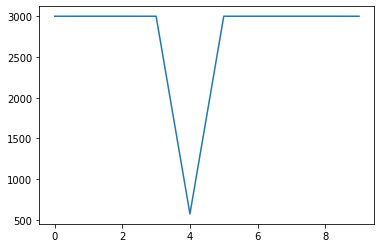

In [8]:
plt.plot(nitertab)
k = np.argmin(nitertab)
print(lamb[k])

In [20]:
k = 0.11
lamb0 = 0.11
mu = 0.1*lamb0
nitermax=3000
step0 = 0.01
ux,uy,CF,step,niter=RecalageDG(original,target,lamb0,mu,nitermax,step0)

iteration : 3  cost function : 991.5489292409991 step : 0.08
iteration : 6  cost function : 991.0173393759147 step : 0.64
iteration : 9  cost function : 988.3526085935334 step : 5.12
iteration : 12  cost function : 984.0229996725819 step : 1.28
iteration : 15  cost function : 982.3414629005548 step : 1.28
iteration : 18  cost function : 981.2187093303119 step : 2.56
iteration : 21  cost function : 979.9880043856464 step : 1.28
iteration : 24  cost function : 978.9382321310683 step : 2.56
iteration : 27  cost function : 977.8715285850824 step : 2.56
iteration : 30  cost function : 976.8853317802957 step : 2.56
iteration : 33  cost function : 975.9147761600632 step : 2.56
iteration : 36  cost function : 974.9892606167771 step : 2.56
iteration : 39  cost function : 974.1292258984022 step : 2.56
iteration : 42  cost function : 973.2638727644619 step : 2.56
iteration : 45  cost function : 972.488770790437 step : 2.56
iteration : 48  cost function : 971.702622262715 step : 1.28
iteration : 5

iteration : 405  cost function : 938.4069287682121 step : 1.28
iteration : 408  cost function : 938.3678112468465 step : 1.28
iteration : 411  cost function : 938.3209988923157 step : 1.28
iteration : 414  cost function : 938.2717696248491 step : 2.56
iteration : 417  cost function : 938.2344007372203 step : 2.56
iteration : 420  cost function : 938.20329079338 step : 2.56
iteration : 423  cost function : 938.1611684570792 step : 2.56
iteration : 426  cost function : 938.1230155853284 step : 2.56
iteration : 429  cost function : 938.067929424493 step : 2.56
iteration : 432  cost function : 938.0161176310564 step : 2.56
iteration : 435  cost function : 937.9594087178415 step : 1.28
iteration : 438  cost function : 937.9189067913499 step : 1.28
iteration : 441  cost function : 937.8674400282417 step : 1.28
iteration : 444  cost function : 937.8178002555305 step : 2.56
iteration : 447  cost function : 937.7806199971626 step : 2.56
iteration : 450  cost function : 937.7519741106668 step : 

In [31]:
res.append([ux,uy,CF,step,niter])

In [29]:
uy[9,:10]


array([-2.56857087, -2.54905738, -2.81002174, -2.94144615, -3.21640772,
       -3.23935713, -3.12812168, -3.24039374, -2.43247189, -2.65607055])

In [31]:
x = [1,-1,3]
y = [-1,-2,-3]

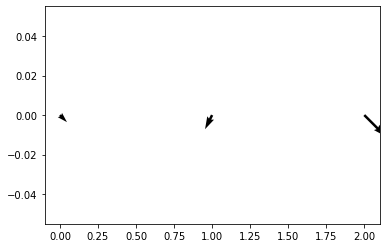

In [32]:
plt.quiver(x,y)
plt.show()


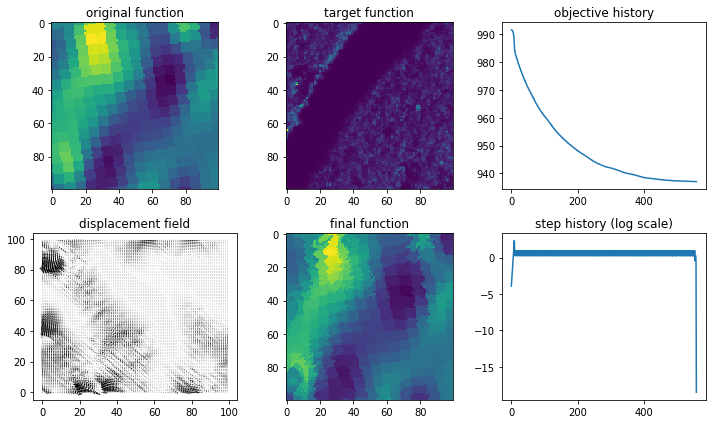

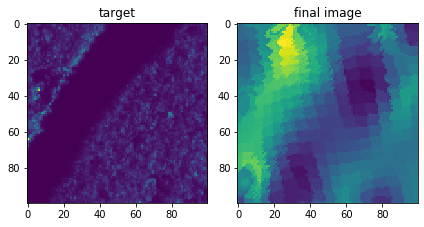

In [22]:
fig, ax = plt.subplots(2,3,figsize=(10,6))
ax[0,0].imshow(original)
ax[0,0].set_title('original function')
ax[0,1].imshow(target)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(original,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.savefig("DG_method.png")
plt.show()
fig,ax = plt.subplots(1,2,figsize=(6,6))
ax[0].imshow(target)
ax[0].set_title("target")
ax[1].imshow(interpol(original,ux,uy))
ax[1].set_title("final image")
plt.tight_layout()


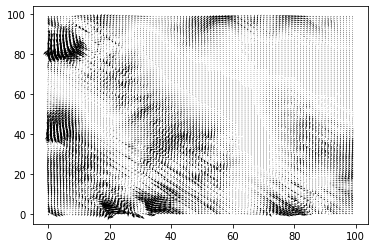

In [20]:
plt.quiver(ux, uy)
plt.show()


### Gradient, pas levenberg marco

In [10]:
lambk = np.linspace(0.0001,0.01,10)
muk = np.copy(lambk)
niter1 = np.zeros(20)
step1=0.01
eps1=0.1
nitermax=3000

for i in range(5) :
    ux,uy,CF,step,niter1[i]=RecalageGN(original,target,lambk[i],muk[i],nitermax,step1,eps1)

iteration : 300  cost function : 517.3693756315369 step : 10.24
iteration : 600  cost function : 496.647903847647 step : 10.24
iteration : 900  cost function : 490.6177585202704 step : 10.24
iteration : 300  cost function : 563.0806636855159 step : 5.12
iteration : 600  cost function : 524.2587408870058 step : 10.24
iteration : 900  cost function : 511.22573563672506 step : 5.12
iteration : 1200  cost function : 508.15523766126 step : 10.24
iteration : 1500  cost function : 505.3196802466426 step : 5.12
iteration : 1800  cost function : 502.00941195494863 step : 5.12
iteration : 2100  cost function : 499.795513947859 step : 5.12
iteration : 2400  cost function : 498.4338607734973 step : 5.12
iteration : 300  cost function : 577.8464871088478 step : 5.12
iteration : 600  cost function : 538.655979407852 step : 10.24
iteration : 900  cost function : 527.1125629499538 step : 5.12
iteration : 1200  cost function : 520.8277820393217 step : 5.12
iteration : 1500  cost function : 513.42534249

Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

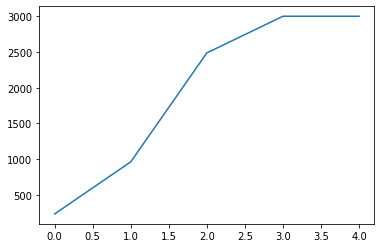

In [12]:
plt.plot(niter1[:5])

In [12]:
epsi=0.1
nitermax=3000
lamb = 0.0001

mu = lamb
step0=0.01
ux,uy,CF,step,niter=RecalageGN(original,target,lamb,mu,nitermax,step0,epsi)
print(niter)

63


In [13]:
k = np.argmin(niter1)
print(lambk[k])

NameError: name 'niter1' is not defined

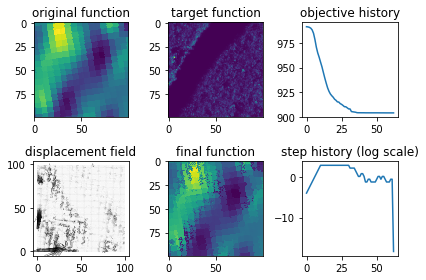

In [14]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(original)
ax[0,0].set_title('original function')
ax[0,1].imshow(target)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(original,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

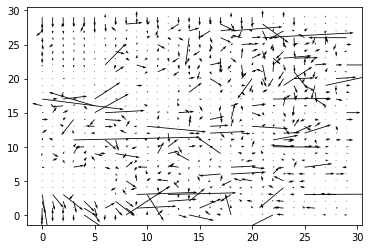

In [37]:
plt.quiver(ux, uy)
plt.show()

5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

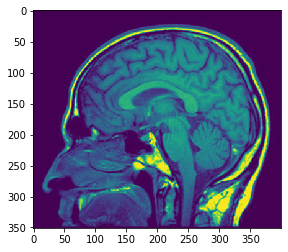

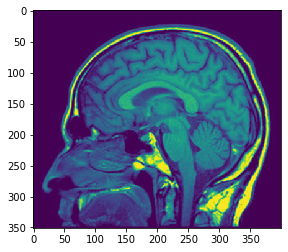

In [13]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [14]:
[n,m]=im1.size
sigma=0.1
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

In [ ]:
epsi=0.01
stepini=0.01
nitermax = 5000
lamb = 0.0001
mu = 0.0001
ux,uy,CF,step, niter=RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi)

iteration : 3  cost function : 0.14378266568826878 step : 0.08
iteration : 6  cost function : 0.1435182966307982 step : 0.64
iteration : 9  cost function : 0.1414353121976472 step : 5.12
iteration : 12  cost function : 0.12664688791055412 step : 40.96
iteration : 15  cost function : 0.07367524667918667 step : 327.68
iteration : 18  cost function : 0.054490660858069626 step : 20.48
iteration : 21  cost function : 0.053399614583654234 step : 20.48
iteration : 24  cost function : 0.053030424409352475 step : 10.24
iteration : 27  cost function : 0.05275613354759687 step : 10.24
iteration : 30  cost function : 0.05251414487138783 step : 10.24
iteration : 33  cost function : 0.05236623483392294 step : 10.24
iteration : 36  cost function : 0.05203014453222114 step : 10.24
iteration : 39  cost function : 0.05190443513327623 step : 5.12
iteration : 42  cost function : 0.051618297422295525 step : 5.12
iteration : 45  cost function : 0.05136707555049709 step : 10.24
iteration : 48  cost function 

In [ ]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()